In [1]:
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

In [2]:
import yaml

with open("../config.yml", 'r') as f:
    cfg = yaml.safe_load(f)

In [3]:
# warnings.simplefilter('ignore')

import torch
import torchvision

import torch.nn as nn
import torch.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.autonotebook import tqdm
import pickle

from utility.util import one_hot
from utility.train import train
from utility.metrics import print_score, nn_accuracy_score
from utility.torchKernel import NeuralTangentKernel

/home/william/.local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Dataset

In [4]:
seed = cfg['other']['random_seed']

torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_size = cfg['dataset']['train_size']
test_size = cfg['dataset']['test_size']

In [6]:
transform =torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,))
                  ])

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(cfg['dataset']['path'], train=True, download=True,
                             transform=transform),
  batch_size=train_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(cfg['dataset']['path'], train=False, download=True,
                             transform=transform),
  batch_size=test_size, shuffle=True)

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [9]:
testiter = iter(test_loader)
images_test, labels_test = testiter.next()

Note that the values $0.1307$ and $0.3081$ are the well known mean and variance for the MNIST dataset.

# Network

In [10]:
n_hidden_nodes = 100

MLP = nn.Sequential(nn.Flatten(), nn.Linear(784, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, 10))

n_channels = 10
CNN = nn.Sequential(nn.Conv2d(1,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels, 10, 16), nn.Flatten())

CNN_t = nn.Sequential(nn.Conv2d(1,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels, 10, 16), nn.Flatten())

In [11]:
def count_params(net):
    return sum(par.numel() for par in net.parameters() if par.requires_grad)

In [12]:
count_params(CNN_t)

30890

In [14]:
optimizer = torch.optim.Adam(CNN_t.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
train(CNN_t, images, labels, criterion, optimizer, nb_epochs=2000)

print_score(CNN_t, criterion, images, labels, images_test, labels_test)
print_score(CNN_t, nn_accuracy_score, images, labels, images_test, labels_test)

CrossEntropyLoss() on TRAIN :	 5.488011083798483e-06 
CrossEntropyLoss() on TEST :	 1.3183327913284302
<function nn_accuracy_score at 0x7f38cc422560> on TRAIN :	 1.0 
<function nn_accuracy_score at 0x7f38cc422560> on TEST :	 0.8759999871253967


In [15]:
NTK = NeuralTangentKernel(images, CNN_t)

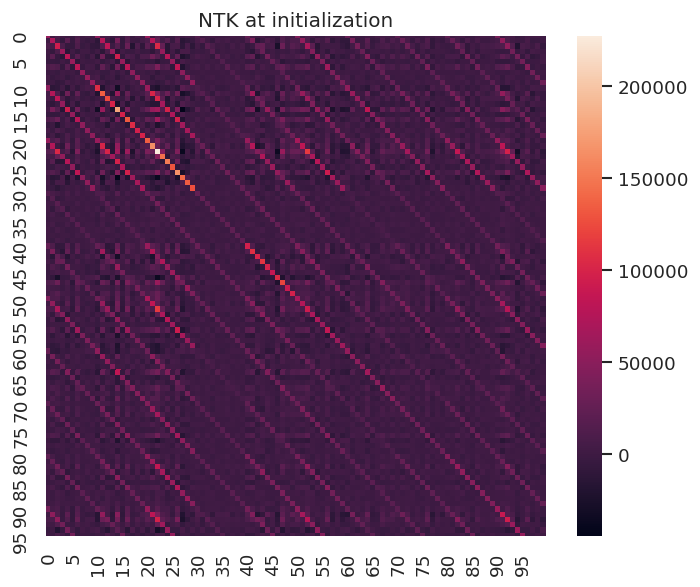

In [16]:
fig, ax1 = plt.subplots(ncols=1, figsize=(6,5), dpi=120)
sns.heatmap(NTK.kernel[:100,:100].cpu(), ax=ax1)
ax1.set(title='NTK at initialization')
plt.tight_layout()
plt.show()


In [18]:
# optimizer = torch.optim.SGD(NTK.parameters(), lr=0.01)
optimizer = torch.optim.Adam(NTK.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
train(NTK, images, labels, criterion, optimizer, nb_epochs=8000)

NeuralTangentKernel()

In [19]:
if True:
    with open(cfg['models']['path']+'/CNN_trained.pkl', mode='wb') as f:
        pickle.dump(NTK, f)

In [20]:
NTK.train(False)

# print_score(NTK, criterion, images, labels, images_test, labels_test)
print_score(NTK, nn_accuracy_score, images, labels, images_test, labels_test)

<function nn_accuracy_score at 0x7f38cc422560> on TRAIN :	 0.9959999918937683 
<function nn_accuracy_score at 0x7f38cc422560> on TEST :	 0.878000020980835


In [25]:
%%time
NTK.train(False)
pred_te_inf = NTK(images_test)

CPU times: user 1min 27s, sys: 794 ms, total: 1min 28s
Wall time: 25.7 s


In [26]:
nn_accuracy_score(pred_te_inf.cpu(), labels_test.cpu())

tensor(0.8020)